In [94]:
import vamb

import numpy as np
import torch as torch
import torch.nn as nn
from torch.optim import Adam as Adam
from torch.utils.data import DataLoader as DataLoader
from torch.utils.data import TensorDataset

from mlxtend.plotting import category_scatter

import wandb

from sklearn.manifold import TSNE

from collections import namedtuple

import os

import glob

import json

import sys

import pandas as pd

import ast

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

torch.manual_seed(0)

# Load Model

In [2]:
class DISENTANGLED_BETA_VAE(torch.nn.Module):
    def __init__(self, nsamples, config):
        super(DISENTANGLED_BETA_VAE, self).__init__()
  
        # SET UP AND CONFIGURE THE MODEL
        self.ntnf = tnfs.shape[1]
        
        self.nlatent = config.nlatent
        self.dropout = config.dropout
        self.learning_rate = config.learning_rate
        self.alpha = config.alpha
        self.beta = config.beta
        self.nepochs = config.nepochs
        
        nhiddens = [512, 512]
        
        self.nsamples = nsamples
        self.cuda_on = False

        self.encoderlayers = torch.nn.ModuleList()
        self.encodernorms = torch.nn.ModuleList()
        self.decoderlayers = torch.nn.ModuleList()
        self.decodernorms = torch.nn.ModuleList()


        # ENCODER LAYERS
        self.encoderlayers.append( torch.nn.Linear((self.nsamples + self.ntnf), 512) )
        self.encodernorms.append( torch.nn.BatchNorm1d(512) )

        self.encoderlayers.append( torch.nn.Linear(512, 512) )
        self.encodernorms.append( torch.nn.BatchNorm1d(512) )


        # LATENT LAYERS
        self.mu = torch.nn.Linear(512, self.nlatent)
        self.logsigma = torch.nn.Linear(512, self.nlatent)


        # DECODER LAYRS
        self.decoderlayers.append(torch.nn.Linear(self.nlatent, 512))
        self.decodernorms.append(torch.nn.BatchNorm1d(512))

        self.decoderlayers.append(torch.nn.Linear(512, 512))
        self.decodernorms.append(torch.nn.BatchNorm1d(512))


        # RECONSTRUCTION LAYER
        self.outputlayer = torch.nn.Linear(512, (self.nsamples + self.ntnf) )


        # ACTIVATIONS
        self.relu = torch.nn.LeakyReLU()
        self.softplus = torch.nn.Softplus()
        self.dropoutlayer = torch.nn.Dropout(p=self.dropout)

        
    ###
    # ENCODE NEW CONTIGS TO LATENT SPACE
    ###
    def encode(self, data_loader):
        self.eval()

        new_data_loader = DataLoader(dataset=data_loader.dataset,
                                      batch_size=data_loader.batch_size,
                                      shuffle=False,
                                      drop_last=False,
                                      num_workers=1,
                                      pin_memory=data_loader.pin_memory)

        depths_array, tnf_array = data_loader.dataset.tensors
        length = len(depths_array)

        latent = np.empty((length, self.nlatent), dtype=np.float32)

        row = 0
        with torch.no_grad():
            for depths, tnf in new_data_loader:
                if self.cuda_on:
                    depths = depths.cuda()
                    tnf = tnf.cuda()

                # Evaluate
                out_depths, out_tnf, mu, logsigma = self(depths, tnf)

                if self.cuda_on:
                    mu = mu.cpu()

                latent[row: row + len(mu)] = mu
                row += len(mu)

        assert row == length
        return latent
    
    ###
    # SPECIFIC ENCODING AND DECODING FUNCTIONS
    ###
    # REPARAMATERIZE
    def reparameterize(self, mu, logsigma):
        epsilon = torch.randn(mu.size(0), mu.size(1))

        if self.cuda_on:
            epsilon = epsilon.cuda()

        epsilon.requires_grad = True

        # See comment above regarding softplus
        latent = mu + epsilon * torch.exp(logsigma/2)

        return latent
    
    
    # ENCODE CONTIGS
    def encode_contigs(self, tensor):
        tensors = list()

        # Hidden layers
        for encoderlayer, encodernorm in zip(self.encoderlayers, self.encodernorms):
            tensor = encodernorm(self.dropoutlayer(self.relu(encoderlayer(tensor))))
            tensors.append(tensor)

        # Latent layers
        mu = self.mu(tensor)
        logsigma = self.softplus(self.logsigma(tensor))

        return mu, logsigma
    
    
    # DECODE CONTIGS
    def decode_contigs(self, tensor):
        tensors = list()

        for decoderlayer, decodernorm in zip(self.decoderlayers, self.decodernorms):
            tensor = decodernorm(self.dropoutlayer(self.relu(decoderlayer(tensor))))
            tensors.append(tensor)

        reconstruction = self.outputlayer(tensor)

        # Decompose reconstruction to depths and tnf signal
        depths_out = reconstruction.narrow(1, 0, self.nsamples)
        tnf_out = reconstruction.narrow(1, self.nsamples, tnfs.shape[1])

        return depths_out, tnf_out
    
    
    ###
    # LOSS CALCULATION
    ###
    # CALCULATE LOSS
    def calc_loss(self, depths_in, depths_out, tnf_in, tnf_out, mu, logsigma):
        ce = (depths_out - depths_in).pow(2).sum(dim=1).mean()
        ce_weight = 1 - 0.15 # alpha

        sse = (tnf_out - tnf_in).pow(2).sum(dim=1).mean()
        kld = -0.5 * (1 + logsigma - mu.pow(2) - logsigma.exp()).sum(dim=1).mean()

        sse_weight = 0.15 / self.ntnf # alpha / ntnf
        # BETA PARAMETER HERE
        kld_weight = 1 / (self.nlatent * self.beta)
        loss = ce * ce_weight + sse * sse_weight + kld * kld_weight

        return loss, ce, sse, kld
    

    ###
    # TRAINING FUNCTIONS
    ###
    # FORWARD
    def forward(self, depths, tnf):
        tensor = torch.cat((depths, tnf), 1)
        mu, logsigma = self.encode_contigs(tensor)
        latent = self.reparameterize(mu, logsigma)
        depths_out, tnf_out = self.decode_contigs(latent)

        return depths_out, tnf_out, mu, logsigma   
        
     
    
    # TRAIN SPECIFIC EPOCH
    def trainepoch(self, data_loader, epoch, optimizer, batchsteps):
        self.train()

        epoch_loss, epoch_kldloss, epoch_sseloss, epoch_celoss = 0, 0, 0, 0

        if epoch in batchsteps:
            data_loader = DataLoader(dataset=data_loader.dataset,
                                      batch_size=data_loader.batch_size * 2,
                                      shuffle=True,
                                      drop_last=True,
                                      num_workers=data_loader.num_workers,
                                      pin_memory=data_loader.pin_memory)

        for depths_in, tnf_in in data_loader:
            depths_in.requires_grad = True
            tnf_in.requires_grad = True

            # CUDE ENABLING
            #depths_in = depths_in.cuda()
            #tnf_in = tnf_in.cuda()

            optimizer.zero_grad()

            depths_out, tnf_out, mu, logsigma = self(depths_in, tnf_in)

            loss, ce, sse, kld = self.calc_loss(depths_in, depths_out, tnf_in,
                                                  tnf_out, mu, logsigma)

            loss.backward()
            optimizer.step()

            epoch_loss = epoch_loss + loss.data.item()
            epoch_kldloss = epoch_kldloss + kld.data.item()
            epoch_sseloss = epoch_sseloss + sse.data.item()
            epoch_celoss = epoch_celoss + ce.data.item()

        print('\tEpoch: {}\tLoss: {:.6f}\tCE: {:.7f}\tSSE: {:.6f}\tKLD: {:.4f}\tBatchsize: {}'.format(
              epoch + 1,
              epoch_loss / len(data_loader),
              epoch_celoss / len(data_loader),
              epoch_sseloss / len(data_loader),
              epoch_kldloss / len(data_loader),
              data_loader.batch_size,
              ))
        wandb.log({
            "epoch": (epoch+1), 
            "loss": epoch_loss / len(data_loader),
            "CELoss": epoch_celoss / len(data_loader),
            "SSELoss": epoch_sseloss / len(data_loader),
            "KLDLoss": epoch_kldloss / len(data_loader),
            "Batchsize": data_loader.batch_size
        })

        return data_loader
    
    
    
    # TRAIN MODEL    
    def trainmodel(self, dataloader, batchsteps=[25, 75, 150, 300], modelfile=None):
        
        batchsteps_set = set()
        
        ncontigs, nsamples = dataloader.dataset.tensors[0].shape
        optimizer = Adam(self.parameters(), lr=self.learning_rate)
        
        
        # TRAIN EPOCH
        for epoch in range(self.nepochs):
            dataloader = self.trainepoch(dataloader, epoch, optimizer, batchsteps_set)

# Load In Data

In [3]:
BASE_DIR = os.getcwd()

In [4]:
def filterclusters(clusters, lengthof):
    filtered_bins = dict()
    print('CLUSTERS:', len(clusters))
    for medoid, contigs in clusters.items():
        binsize = sum(lengthof[contig] for contig in contigs)
    
        if binsize >= 10000:
            filtered_bins[medoid] = contigs
    
    return filtered_bins

In [119]:
SIM_FASTA_FILES =  glob.glob('example_input_data/new_simulations/complexity_sim*/*sample_0*')


for SIM_FASTA_FILE in SIM_FASTA_FILES:
    vamb_inputs_base = os.path.join(SIM_FASTA_FILE,'vamb_inputs')
    
    contignames = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'contignames.npz'))
    lengths = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'lengths.npz'))
    tnfs = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'tnfs.npz'))   
    rpkms = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'rpkms.npz'))
    
    print(tnfs.shape)
    print(rpkms.shape)
    
    
    # ADAPT THROUGH DATALOADER
    depthssum = rpkms.sum(axis=1)
    mask = tnfs.sum(axis=1) != 0
    mask &= depthssum != 0
    depthssum = depthssum[mask]

    rpkm = rpkms[mask].astype(np.float32, copy=False)
    tnf = tnfs[mask].astype(np.float32, copy=False)

    ## lkj
    def calculate_z_score(array):
        array_mean = array.mean(axis=0)
        array_std = array.std(axis=0)

        shape = np.copy(array.shape)
        shape[0] = 1
        shape = tuple(shape)

        array_mean.shape = shape
        array_mean.shape = shape

        array = (array - array_mean) / array_std

        return(array)

    rpkm = calculate_z_score(rpkm)
    tnf = calculate_z_score(tnf)
    depthstensor = torch.from_numpy(rpkm)
    tnftensor = torch.from_numpy(tnf)

    n_workers = 1

    dataset = TensorDataset(depthstensor, tnftensor)
    dataloader = DataLoader(dataset=dataset, batch_size=256, drop_last=True,
                                 shuffle=True, num_workers=n_workers, pin_memory=False)



    ncontigs, nsamples = dataset.tensors[0].shape
    
    
    # RUN BETA VAE
    best_params_dict = {
        'nepochs': 150,
        'dropout': 0.2,
        'learning_rate': 1e-3,
        'alpha': 0.15,
        'beta': 200,
        'nlatent': 32
    }

    best_params = namedtuple('GenericDict', best_params_dict.keys())(**best_params_dict)

    beta_vae = DISENTANGLED_BETA_VAE(nsamples=rpkms.shape[1], config=best_params)
    wandb.init()
    wandb.watch(beta_vae)
    beta_vae.trainmodel(dataloader, batchsteps=None)
    #beta_vae.load_state_dict(torch.load('model.h5'))

    latent = beta_vae.encode(dataloader)
    print("Latent shape:", latent.shape)

    latent_output_path = os.path.join(SIM_FASTA_FILE, 'latent_space.npy')
    with open(latent_output_path, 'wb') as outfile:
        np.save(outfile, latent)
        
        
    # CONTIG MAPPING
    contig_mapping_table_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/gsa_mapping.tsv")
    contig_mapping_table_comp = contig_mapping_table_path + '.gz'
    if (not os.path.exists(contig_mapping_table_path)) and (os.path.exists(contig_mapping_table_comp)):
        !gzip -d $contig_mapping_table_comp
        
    contig_mapping_table = pd.read_csv(contig_mapping_table_path, sep='\t')
    

    contig_mapping_output_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/encoding_mapping.tsv")    

    contig_mapping_table[contig_mapping_table['#anonymous_contig_id'].isin(contignames)].reset_index().drop('index', axis=1).set_index(
        '#anonymous_contig_id').reindex(contignames).to_csv(contig_mapping_output_path, sep='\t')
    
    
    filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
    cluster_iterator = vamb.cluster.cluster(latent, labels=filtered_labels)
    clusters = dict(cluster_iterator)

    medoid, contigs = next(iter(clusters.items()))
    print('First key:', medoid, '(of type:', type(medoid), ')')
    print('Type of values:', type(contigs))
    print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))
    
    
    # FILTER CLUSTERS  
    lengthof = dict(zip(contignames, lengths))
    filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
    print('Number of bins before splitting and filtering:', len(clusters))
    print('Number of bins after splitting and filtering:', len(filtered_bins))
    
    
    # SAVE OUTPUTS
    vamb_outputs_base = os.path.join(BASE_DIR, SIM_FASTA_FILE)


    # This writes a .tsv file with the clusters and corresponding sequences
    with open(os.path.join(vamb_outputs_base, 'clusters_dvae.tsv'), 'w') as file:
        vamb.vambtools.write_clusters(file, filtered_bins)

    # Only keep contigs in any filtered bin in memory
    keptcontigs = set.union(*filtered_bins.values())

    # decompress fasta.gz if present
    fasta_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/anonymous_gsa.fasta.gz")
    if os.path.exists(fasta_path) and not os.path.exists(fasta_path.replace('.fasta.gz','.fasta')):
        !gzip -dk $fasta_path


    with open(os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/anonymous_gsa.fasta"), 'rb') as file:
        fastadict = vamb.vambtools.loadfasta(file, keep=keptcontigs)

    bindir = os.path.join(vamb_outputs_base, 'dvae_bins')
    if not os.path.exists(bindir):
        os.mkdir(bindir)
    vamb.vambtools.write_bins(bindir, filtered_bins, fastadict, maxbins=500)
    
    
    # RUN CHECKM
    CHECKM_OUTDIR = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'checkm_results')

    if not os.path.exists(CHECKM_OUTDIR):
        os.mkdir(CHECKM_OUTDIR)

        
    bins_inpath = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'dvae_bins')
    bins_inpath_clean = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'dvae_bins_clean')
    
    if not os.path.exists(bins_inpath_clean):
        os.mkdir(bins_inpath_clean)

    for bin_file in glob.glob(os.path.join(bins_inpath,'*')):
        bin_outfile = bin_file.replace('dvae_bins','dvae_bins_clean')
        !sed -e 's/\r$//' $bin_file > $bin_outfile

    !~/miniconda3/envs/vamb_env/bin/checkm lineage_wf -t 32 -x fna $bins_inpath_clean $CHECKM_OUTDIR

(774, 103)
(774, 1)


epoch,150
loss,0.0788
CELoss,0.02483
SSELoss,33.61918
KLDLoss,111.85435
Batchsize,256
_runtime,35
_timestamp,1615823017
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▃▅▆▇▇██████████▇▇▇▇▇▇▆▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.251885	CE: 1.2397954	SSE: 134.394145	KLD: 14.9727	Batchsize: 256
	Epoch: 2	Loss: 0.766129	CE: 0.7041061	SSE: 112.663628	KLD: 22.8206	Batchsize: 256
	Epoch: 3	Loss: 0.695189	CE: 0.6587537	SSE: 89.618680	KLD: 30.3117	Batchsize: 256
	Epoch: 4	Loss: 0.527663	CE: 0.4762020	SSE: 80.365318	KLD: 37.4700	Batchsize: 256
	Epoch: 5	Loss: 0.432989	CE: 0.3720198	SSE: 75.552465	KLD: 43.1631	Batchsize: 256
	Epoch: 6	Loss: 0.385019	CE: 0.3227837	SSE: 70.691444	KLD: 49.3071	Batchsize: 256
	Epoch: 7	Loss: 0.352349	CE: 0.2897602	SSE: 66.933451	KLD: 54.8943	Batchsize: 256
	Epoch: 8	Loss: 0.286742	CE: 0.2179240	SSE: 63.363787	KLD: 59.0692	Batchsize: 256
	Epoch: 9	Loss: 0.258398	CE: 0.1877009	SSE: 61.171902	KLD: 62.5091	Batchsize: 256
	Epoch: 10	Loss: 0.263138	CE: 0.1971755	SSE: 58.534318	KLD: 65.8836	Batchsize: 256
	Epoch: 11	Loss: 0.212216	CE: 0.1397541	SSE: 56.637277	KLD: 70.0365	Batchsize: 256
	Epoch: 12	Loss: 0.220946	CE: 0.1511624	SSE: 55.767869	KLD: 71.9521	Batchsize: 256
	Epoch: 13	

epoch,150
loss,0.08746
CELoss,0.03278
SSELoss,32.17315
KLDLoss,81.51641
Batchsize,256
_runtime,22
_timestamp,1615825950
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▃▅▆▇███████████████████████████████▇▇▇▇
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.253970	CE: 1.2403517	SSE: 135.656509	KLD: 13.5245	Batchsize: 256
	Epoch: 2	Loss: 1.159583	CE: 1.1365846	SSE: 131.000542	KLD: 17.3358	Batchsize: 256
	Epoch: 3	Loss: 0.821593	CE: 0.7463731	SSE: 126.092247	KLD: 22.6953	Batchsize: 256
	Epoch: 4	Loss: 0.731466	CE: 0.6487291	SSE: 120.857838	KLD: 25.8512	Batchsize: 256
	Epoch: 5	Loss: 0.738704	CE: 0.6623369	SSE: 117.449135	KLD: 29.9222	Batchsize: 256
	Epoch: 6	Loss: 0.570593	CE: 0.4727518	SSE: 112.402870	KLD: 32.3899	Batchsize: 256
	Epoch: 7	Loss: 0.553489	CE: 0.4589700	SSE: 108.313251	KLD: 36.0091	Batchsize: 256
	Epoch: 8	Loss: 0.491963	CE: 0.3883754	SSE: 104.380909	KLD: 62.9296	Batchsize: 256
	Epoch: 9	Loss: 0.454019	CE: 0.3515009	SSE: 102.180916	KLD: 41.1905	Batchsize: 256
	Epoch: 10	Loss: 0.434618	CE: 0.3349174	SSE: 98.247002	KLD: 43.9055	Batchsize: 256
	Epoch: 11	Loss: 0.409065	CE: 0.3059998	SSE: 97.202454	KLD: 47.4097	Batchsize: 256
	Epoch: 12	Loss: 0.386521	CE: 0.2871950	SSE: 92.355068	KLD: 50.6063	Batchsize: 256
	Epo

epoch,150
loss,0.11866
CELoss,0.02587
SSELoss,55.15044
KLDLoss,104.68512
Batchsize,256
_runtime,19
_timestamp,1615826402
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▇▆▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▁▃▂█▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄▄▄▅
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.154243	CE: 1.1365575	SSE: 127.518085	KLD: 15.7663	Batchsize: 256
	Epoch: 2	Loss: 0.740568	CE: 0.6839755	SSE: 106.553352	KLD: 25.6914	Batchsize: 256
	Epoch: 3	Loss: 0.479866	CE: 0.3907496	SSE: 97.545919	KLD: 36.2981	Batchsize: 256
	Epoch: 4	Loss: 0.367677	CE: 0.2676153	SSE: 91.021310	KLD: 48.9522	Batchsize: 256
	Epoch: 5	Loss: 0.305328	CE: 0.1991438	SSE: 86.730245	KLD: 62.3992	Batchsize: 256
	Epoch: 6	Loss: 0.260336	CE: 0.1522214	SSE: 82.731405	KLD: 66.9780	Batchsize: 256
	Epoch: 7	Loss: 0.240690	CE: 0.1316639	SSE: 80.687576	KLD: 72.1237	Batchsize: 256
	Epoch: 8	Loss: 0.224591	CE: 0.1148109	SSE: 78.820665	KLD: 78.1712	Batchsize: 256
	Epoch: 9	Loss: 0.219178	CE: 0.1105732	SSE: 77.169882	KLD: 81.9691	Batchsize: 256
	Epoch: 10	Loss: 0.199462	CE: 0.0900933	SSE: 75.102952	KLD: 86.4579	Batchsize: 256
	Epoch: 11	Loss: 0.197903	CE: 0.0885955	SSE: 74.466406	KLD: 90.5631	Batchsize: 256
	Epoch: 12	Loss: 0.195801	CE: 0.0880046	SSE: 73.115399	KLD: 92.9199	Batchsize: 256
	Epoch: 13	

epoch,150
loss,0.11174
CELoss,0.03017
SSELoss,49.26465
KLDLoss,91.84144
Batchsize,256
_runtime,55
_timestamp,1615826895
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▃▅▇▇████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.070580	CE: 1.0645833	SSE: 111.547324	KLD: 20.7151	Batchsize: 256
	Epoch: 2	Loss: 0.714179	CE: 0.6980135	SSE: 78.597276	KLD: 40.9965	Batchsize: 256
	Epoch: 3	Loss: 0.588917	CE: 0.5678170	SSE: 67.454230	KLD: 51.4458	Batchsize: 256
	Epoch: 4	Loss: 0.492300	CE: 0.4625885	SSE: 61.837819	KLD: 57.8877	Batchsize: 256
	Epoch: 5	Loss: 0.365631	CE: 0.3153503	SSE: 57.818602	KLD: 85.6432	Batchsize: 256
	Epoch: 6	Loss: 0.337598	CE: 0.2877050	SSE: 54.728681	KLD: 85.4165	Batchsize: 256
	Epoch: 7	Loss: 0.297975	CE: 0.2462080	SSE: 52.104641	KLD: 82.0357	Batchsize: 256
	Epoch: 8	Loss: 0.298807	CE: 0.2483550	SSE: 51.014062	KLD: 85.8432	Batchsize: 256
	Epoch: 9	Loss: 0.242480	CE: 0.1853192	SSE: 48.341697	KLD: 93.1723	Batchsize: 256
	Epoch: 10	Loss: 0.223783	CE: 0.1645844	SSE: 47.790760	KLD: 91.4412	Batchsize: 256
	Epoch: 11	Loss: 0.217515	CE: 0.1587295	SSE: 46.638024	KLD: 93.9230	Batchsize: 256
	Epoch: 12	Loss: 0.202744	CE: 0.1426781	SSE: 45.863592	KLD: 93.9232	Batchsize: 256
	Epoch: 13	L

epoch,150
loss,0.0871
CELoss,0.03575
SSELoss,30.46893
KLDLoss,78.97484
Batchsize,256
_runtime,33
_timestamp,1615827436
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▃▆▇█▇███████▇█▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.112566	CE: 1.0884506	SSE: 126.998311	KLD: 15.5793	Batchsize: 256
	Epoch: 2	Loss: 0.622084	CE: 0.5582431	SSE: 98.582083	KLD: 25.6718	Batchsize: 256
	Epoch: 3	Loss: 0.414190	CE: 0.3394067	SSE: 82.119432	KLD: 39.0588	Batchsize: 256
	Epoch: 4	Loss: 0.324763	CE: 0.2404218	SSE: 77.231046	KLD: 50.7682	Batchsize: 256
	Epoch: 5	Loss: 0.278527	CE: 0.1958229	SSE: 70.474625	KLD: 60.4464	Batchsize: 256
	Epoch: 6	Loss: 0.244617	CE: 0.1607822	SSE: 66.780966	KLD: 68.4720	Batchsize: 256
	Epoch: 7	Loss: 0.214802	CE: 0.1297094	SSE: 63.819475	KLD: 74.2888	Batchsize: 256
	Epoch: 8	Loss: 0.201202	CE: 0.1176259	SSE: 61.065285	KLD: 78.6580	Batchsize: 256
	Epoch: 9	Loss: 0.191767	CE: 0.1082420	SSE: 59.764126	KLD: 81.4463	Batchsize: 256
	Epoch: 10	Loss: 0.179704	CE: 0.0959149	SSE: 58.390243	KLD: 84.1057	Batchsize: 256
	Epoch: 11	Loss: 0.172619	CE: 0.0891563	SSE: 57.374865	KLD: 84.9987	Batchsize: 256
	Epoch: 12	Loss: 0.174474	CE: 0.0934245	SSE: 56.108500	KLD: 85.4487	Batchsize: 256
	Epoch: 13	L

epoch,150
loss,0.08466
CELoss,0.02549
SSELoss,35.00546
KLDLoss,76.85403
Batchsize,256
_runtime,31
_timestamp,1615827954
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▄▆▇▇▇▇███████████▇█▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.188720	CE: 1.1851691	SSE: 122.743254	KLD: 16.4706	Batchsize: 256
	Epoch: 2	Loss: 0.659344	CE: 0.6015861	SSE: 98.448712	KLD: 29.5945	Batchsize: 256
	Epoch: 3	Loss: 0.402115	CE: 0.3090332	SSE: 90.934475	KLD: 44.8500	Batchsize: 256
	Epoch: 4	Loss: 0.322408	CE: 0.2221427	SSE: 85.209239	KLD: 60.7701	Batchsize: 256
	Epoch: 5	Loss: 0.265816	CE: 0.1579491	SSE: 82.023450	KLD: 77.4897	Batchsize: 256
	Epoch: 6	Loss: 0.235230	CE: 0.1268716	SSE: 78.935600	KLD: 79.5823	Batchsize: 256
	Epoch: 7	Loss: 0.215924	CE: 0.1060573	SSE: 77.154391	KLD: 85.8504	Batchsize: 256
	Epoch: 8	Loss: 0.204127	CE: 0.0936649	SSE: 75.531385	KLD: 92.8931	Batchsize: 256
	Epoch: 9	Loss: 0.197502	CE: 0.0877183	SSE: 73.945301	KLD: 97.6281	Batchsize: 256
	Epoch: 10	Loss: 0.196903	CE: 0.0877061	SSE: 73.147661	KLD: 101.2930	Batchsize: 256
	Epoch: 11	Loss: 0.184476	CE: 0.0748189	SSE: 71.894469	KLD: 103.5463	Batchsize: 256
	Epoch: 12	Loss: 0.180343	CE: 0.0707915	SSE: 71.225118	KLD: 105.2411	Batchsize: 256
	Epoch: 1

epoch,150
loss,0.11481
CELoss,0.03121
SSELoss,50.45865
KLDLoss,94.72723
Batchsize,256
_runtime,38
_timestamp,1615828474
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▄▆▇█████▇▇▇▇▇▇▇▇▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▆▇▇▇
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.251936	CE: 1.2380987	SSE: 135.577858	KLD: 13.4967	Batchsize: 256
	Epoch: 2	Loss: 0.986335	CE: 0.9391226	SSE: 126.981281	KLD: 20.2016	Batchsize: 256
	Epoch: 3	Loss: 0.779841	CE: 0.7170724	SSE: 114.169857	KLD: 26.0034	Batchsize: 256
	Epoch: 4	Loss: 0.625823	CE: 0.5501098	SSE: 105.345257	KLD: 30.8100	Batchsize: 256
	Epoch: 5	Loss: 0.553337	CE: 0.4661712	SSE: 104.193790	KLD: 34.2596	Batchsize: 256
	Epoch: 6	Loss: 0.555959	CE: 0.4720387	SSE: 102.253128	KLD: 37.2065	Batchsize: 256
	Epoch: 7	Loss: 0.481137	CE: 0.3904876	SSE: 97.989822	KLD: 41.7183	Batchsize: 256
	Epoch: 8	Loss: 0.493208	CE: 0.4106833	SSE: 94.339653	KLD: 43.1350	Batchsize: 256
	Epoch: 9	Loss: 0.387685	CE: 0.2918524	SSE: 90.920918	KLD: 46.0872	Batchsize: 256
	Epoch: 10	Loss: 0.395808	CE: 0.3044244	SSE: 88.940674	KLD: 48.1436	Batchsize: 256
	Epoch: 11	Loss: 0.370073	CE: 0.2818017	SSE: 84.065907	KLD: 51.9391	Batchsize: 256
	Epoch: 12	Loss: 0.325087	CE: 0.2301041	SSE: 83.066490	KLD: 54.5786	Batchsize: 256
	Epoch:

epoch,150
loss,0.11343
CELoss,0.03572
SSELoss,47.54912
KLDLoss,88.43742
Batchsize,256
_runtime,22
_timestamp,1615828943
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▅▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▂▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██▇█▇████████████
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.019351	CE: 0.9740915	SSE: 129.657481	KLD: 16.3278	Batchsize: 256
	Epoch: 2	Loss: 0.602272	CE: 0.5160083	SSE: 109.381135	KLD: 27.9777	Batchsize: 256
	Epoch: 3	Loss: 0.489107	CE: 0.3996003	SSE: 98.394040	KLD: 39.3856	Batchsize: 256
	Epoch: 4	Loss: 0.391574	CE: 0.3026362	SSE: 86.831210	KLD: 50.4313	Batchsize: 256
	Epoch: 5	Loss: 0.321272	CE: 0.2293062	SSE: 80.263615	KLD: 60.6255	Batchsize: 256
	Epoch: 6	Loss: 0.283400	CE: 0.1893059	SSE: 76.823683	KLD: 67.9074	Batchsize: 256
	Epoch: 7	Loss: 0.271005	CE: 0.1802159	SSE: 73.094147	KLD: 72.7899	Batchsize: 256
	Epoch: 8	Loss: 0.242624	CE: 0.1503563	SSE: 70.961969	KLD: 73.4593	Batchsize: 256
	Epoch: 9	Loss: 0.228076	CE: 0.1353489	SSE: 69.725402	KLD: 73.5217	Batchsize: 256
	Epoch: 10	Loss: 0.214611	CE: 0.1197787	SSE: 69.236986	KLD: 76.5988	Batchsize: 256
	Epoch: 11	Loss: 0.196133	CE: 0.1010839	SSE: 67.285961	KLD: 78.2266	Batchsize: 256
	Epoch: 12	Loss: 0.191754	CE: 0.0977172	SSE: 66.126292	KLD: 79.3202	Batchsize: 256
	Epoch: 13	

epoch,150
loss,0.09694
CELoss,0.02266
SSELoss,44.46931
KLDLoss,82.62855
Batchsize,256
_runtime,32
_timestamp,1615829399
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▃▅▆▇▇███████████▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 0.926932	CE: 0.8885552	SSE: 115.511829	KLD: 22.0110	Batchsize: 256
	Epoch: 2	Loss: 0.511881	CE: 0.4531856	SSE: 82.134531	KLD: 45.1838	Batchsize: 256
	Epoch: 3	Loss: 0.404602	CE: 0.3433251	SSE: 70.770184	KLD: 62.1557	Batchsize: 256
	Epoch: 4	Loss: 0.318807	CE: 0.2508426	SSE: 64.964324	KLD: 70.2881	Batchsize: 256
	Epoch: 5	Loss: 0.272869	CE: 0.2031243	SSE: 60.977740	KLD: 73.0290	Batchsize: 256
	Epoch: 6	Loss: 0.227075	CE: 0.1532113	SSE: 58.420797	KLD: 75.3059	Batchsize: 256
	Epoch: 7	Loss: 0.204304	CE: 0.1300723	SSE: 56.086842	KLD: 77.1992	Batchsize: 256
	Epoch: 8	Loss: 0.183139	CE: 0.1067179	SSE: 54.514329	KLD: 83.4496	Batchsize: 256
	Epoch: 9	Loss: 0.172624	CE: 0.0955884	SSE: 53.504895	KLD: 86.1083	Batchsize: 256
	Epoch: 10	Loss: 0.174356	CE: 0.0991199	SSE: 52.506971	KLD: 87.2827	Batchsize: 256
	Epoch: 11	Loss: 0.152931	CE: 0.0759077	SSE: 50.993559	KLD: 90.5414	Batchsize: 256
	Epoch: 12	Loss: 0.150793	CE: 0.0734298	SSE: 50.532518	KLD: 94.6332	Batchsize: 256
	Epoch: 13	L

In [122]:
print('done')

done


# Compile Outputs

In [123]:
SIM_FASTA_FILES =  glob.glob('example_input_data/new_simulations/complexity_sim*/*sample_0*')

experiment_beta = best_params_dict['beta'] 

experiment_path = f"experiment_beta{experiment_beta}"

if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

num_generas = []
num_genomes = []
num_bins = []
num_mappable_bins = []
mean_completenesses = []
mean_contaminations = []


for SIM_FASTA_FILE in SIM_FASTA_FILES:
    num_genera, num_genome = SIM_FASTA_FILE.split('/')[-2].split('_')[2], SIM_FASTA_FILE.split('/')[-2].split('_')[4]
    
    checkm_data = os.path.join(SIM_FASTA_FILE, 'checkm_results')

    num_bin = len(glob.glob(os.path.join(checkm_data,'bins','*')))
    
    t1 = pd.read_csv( os.path.join(checkm_data, 'storage', 'bin_stats_ext.tsv'), sep ='\t', names=['contig', 'data'])
    t1 = t1[~t1['data'].str.contains("'Completeness': 0.0")]
    
    num_mappable_bin = len(t1)
    
    completeness = np.array([ast.literal_eval(i)['Completeness'] for i in t1['data'].values])
    contamination = np.array([ast.literal_eval(i)['Contamination'] for i in t1['data'].values])
    
    mean_completeness = completeness.mean()
    mean_contamination = contamination.mean()
    
    num_generas.append(num_genera)
    num_genomes.append(num_genome)
    num_bins.append(num_bin)
    num_mappable_bins.append(num_mappable_bin)
    mean_completenesses.append(mean_completeness)
    mean_contaminations.append(mean_contamination)
    
    
    latent_encoding_labels = pd.read_csv(glob.glob(os.path.join(SIM_FASTA_FILE, 'encoding_mapping.tsv'))[0], sep='\t')
    latent_output_path = glob.glob(os.path.join(SIM_FASTA_FILE, 'latent_space.npy'))[0]

    with open(latent_output_path, 'rb') as infile:
        latent_space = np.load(infile)

    tsne_results = pd.DataFrame(TSNE(n_components=2).fit_transform(latent_space))
    tsne_results['genome_id'] = latent_encoding_labels['genome_id']
    tsne_filename = SIM_FASTA_FILE.split('/')[-2]
    tsne_results.to_csv(os.path.join(experiment_path, f"{tsne_filename}_tsne.tsv"), sep='\t')
    
    
   
   
experiment_stats = pd.DataFrame(data={
    'num_genera':num_generas,
    'num_genomes':num_genomes,
    'num_bins':num_bins,
    'num_mappable_bins':num_mappable_bins,
    'mean_completeness':mean_completenesses,
    'mean_contamination':mean_contaminations,
    'beta':experiment_beta,
    'dropout':best_params_dict['dropout']
})

experiment_stats.to_csv(f"{experiment_path}/experiment_stats_beta{experiment_beta}.tsv", sep='\t', index=False)

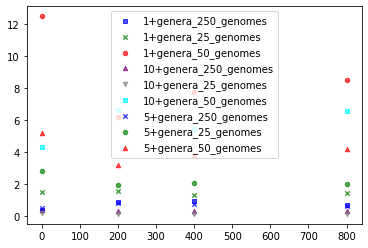

In [146]:
experiment_stats_all = pd.concat([pd.read_csv(i, sep='\t') for i in glob.glob('experiment_beta*/experiment_stats*.tsv')])
experiment_stats_all['experiment'] = experiment_stats_all['num_genera'].astype(str) + '+genera_' + experiment_stats_all['num_genomes'].astype(str) + '_genomes'


fig = category_scatter(x='beta', y='mean_contamination', label_col='experiment', 
                       data=experiment_stats_all)# legend_loc='upper left')
plt.show()

In [29]:
pd.read_csv(f"experiment_beta{experiment_beta}/experiment_stats_beta{experiment_beta}.tsv", sep='\t')

,num_genera,num_genomes,num_bins,num_mappable_bins,mean_completeness,mean_contamination,beta,dropout
0,10,250,29,7,35.367005,0.387696,1,0.2
1,1,250,133,9,11.004557,0.410424,1,0.2
2,1,25,189,14,16.133731,1.513042,1,0.2
3,5,50,75,8,49.573638,5.219702,1,0.2
4,10,25,193,20,10.836362,0.224332,1,0.2
5,1,50,77,5,35.000355,12.480161,1,0.2
6,5,250,59,6,31.815141,0.512513,1,0.2
7,5,25,158,9,29.103874,2.806890,1,0.2
8,10,50,107,22,15.176583,4.291655,1,0.2


In [124]:
pd.read_csv(f"experiment_beta{experiment_beta}/experiment_stats_beta{experiment_beta}.tsv", sep='\t')

,num_genera,num_genomes,num_bins,num_mappable_bins,mean_completeness,mean_contamination,beta,dropout
0,10,250,51,19,35.105822,0.314559,200,0.2
1,1,250,142,14,24.122196,0.870878,200,0.2
2,1,25,212,17,19.194367,1.557420,200,0.2
3,5,50,131,28,40.942619,3.201515,200,0.2
4,10,25,295,33,9.634855,0.135959,200,0.2
5,1,50,116,12,24.493177,6.167656,200,0.2
6,5,250,75,11,44.847036,0.830812,200,0.2
7,5,25,201,20,38.909649,1.933880,200,0.2
8,10,50,175,39,19.486343,6.594385,200,0.2


In [113]:
pd.read_csv(f"experiment_beta{experiment_beta}/experiment_stats_beta{experiment_beta}.tsv", sep='\t')

,num_genera,num_genomes,num_bins,num_mappable_bins,mean_completeness,mean_contamination,beta,dropout
0,10,250,45,15,34.707670,0.324488,400,0.2
1,1,250,139,12,19.340885,0.948323,400,0.2
2,1,25,200,16,14.524375,1.323912,400,0.2
3,5,50,108,20,43.333994,3.824773,400,0.2
4,10,25,282,31,9.774104,0.144731,400,0.2
5,1,50,98,9,27.367071,7.763277,400,0.2
6,5,250,71,10,39.502991,0.732663,400,0.2
7,5,25,190,17,36.522143,2.036433,400,0.2
8,10,50,143,33,18.246001,5.409019,400,0.2


In [34]:
pd.read_csv(f"experiment_beta{experiment_beta}/experiment_stats_beta{experiment_beta}.tsv", sep='\t')

,num_genera,num_genomes,num_bins,num_mappable_bins,mean_completeness,mean_contamination,beta,dropout
0,10,250,37,12,32.515300,0.340224,800,0.2
1,1,250,137,10,11.542033,0.714209,800,0.2
2,1,25,197,15,15.335927,1.412173,800,0.2
3,5,50,92,15,45.279762,4.159852,800,0.2
4,10,25,264,28,9.701293,0.160237,800,0.2
5,1,50,93,8,29.259742,8.518169,800,0.2
6,5,250,66,8,36.620047,0.650107,800,0.2
7,5,25,177,14,32.553189,1.985435,800,0.2
8,10,50,116,27,19.463007,6.576718,800,0.2


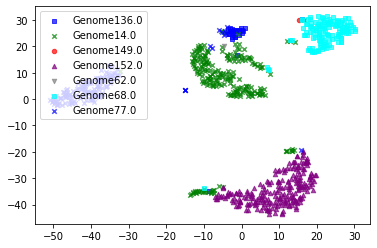

In [108]:
tsne_results = pd.read_csv('experiment_beta1/complexity_sim_10_genera_250_genomes_tsne.tsv', sep='\t')
fig = category_scatter(x='0', y='1', label_col='genome_id', 
                       data=tsne_results, legend_loc='upper left')

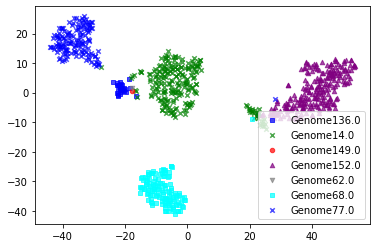

In [118]:
tsne_results = pd.read_csv('experiment_beta400/complexity_sim_10_genera_250_genomes_tsne.tsv', sep='\t')
fig = category_scatter(x='0', y='1', label_col='genome_id', 
                       data=tsne_results, legend_loc='lower right')

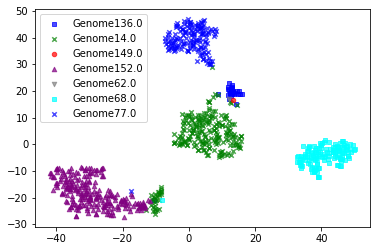

In [109]:
tsne_results = pd.read_csv('experiment_beta800/complexity_sim_10_genera_250_genomes_tsne.tsv', sep='\t')
fig = category_scatter(x='0', y='1', label_col='genome_id', 
                       data=tsne_results, legend_loc='upper left')